In [104]:
!pip install datasets > /dev/null

In [105]:
import sys  # модуль для взаємодії з системою
from typing import List, Tuple, Mapping  # використовуємо для визначення типів даних

import datasets  # бібліотека для роботи з даними
from tqdm import tqdm  # для створення прогрес-бару
import numpy as np  # для роботи з масивами даних
import matplotlib.pyplot as plt  # для візуалізації

import torch  # бібліотека для навчання нейромереж
import torch.nn as nn  # модуль нейронних мереж
import torch.optim as optim  # оптимізатори
import torch.nn.functional as F  # функціональні операції над тензорами
from torch.nn.utils.rnn import pad_sequence  # для вирівнювання послідовностей
from torch.utils.data import Dataset, DataLoader  # для роботи з даними та завантаження їх у модель
from torch.optim import lr_scheduler

## Dataset

**[HuggingFace](https://huggingface.co/datasets/benjamin/ner-uk)** <br>
**[GitHub](https://github.com/lang-uk/ner-uk/tree/master)**

In [106]:
dataset = datasets.load_dataset("benjamin/ner-uk")  # завантаження набору даних для розпізнавання іменованих сутностей українською мовою
dataset  # виведення набору даних

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 10833
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 1307
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 668
    })
})

In [107]:
# NOTE: буде використано для вирівнювання вхідних послідовностей.
TOK_PAD_ID = 0

vocab = {"<PAD>": TOK_PAD_ID}  # словник, починаємо з індексу для заповнення
curr_idx = 1  # поточний індекс для індексування слів
for split in ("train", "validation", "test"):  # проходимо по наборах даних для навчання, валідації та тестування
    for sample in dataset[split]:  # проходимо по кожному зразку в наборі даних
        for word in sample["tokens"]:  # проходимо по кожному слову в токенах зразку
            if word not in vocab:  # якщо слово ще не зустрічалося
                vocab[word] = curr_idx  # додаємо його до словника з поточним індексом
                curr_idx += 1  # збільшуємо поточний індекс

print("Vocab size:", len(vocab))  # виводимо розмір словника

Vocab size: 50205


In [108]:
# NOTE: буде використано це значення для вирівнювання міток,
#       у функції CrossEntropyLoss є спеціальний параметр, який називається 'ignore_index'
#       і він ігноруватиме мітки з цим значенням (обчислення втрат
#       буде пропущено для міток, які дорівнюють цьому значенню)
NER_PAD_ID = -100

targets = set()  # множина для зберігання унікальних міток іменованих сутностей
for split in ("train", "validation", "test"):  # проходимо по наборах даних для навчання, валідації та тестування
    for sample in dataset[split]:  # проходимо по кожному зразку в наборі даних
        targets.update(sample["ner_tags"])  # додаємо усі мітки зразку до множини

targets = sorted(targets)  # сортуємо унікальні мітки
print("Unique targets:", len(targets))  # виводимо кількість унікальних міток
targets  # виводимо унікальні мітки

Unique targets: 9


[0, 1, 2, 3, 4, 5, 6, 7, 8]

## PyTorch Datasets & DataLoaders

In [109]:
class NERDataset(Dataset):
    def __init__(self, samples: datasets.Dataset, vocabulary: Mapping[str, int]) -> None:
        self.samples = samples  # зразки даних
        self.vocabulary = vocabulary  # словник токенів та їх індексів

    def __len__(self) -> int:
        return len(self.samples)  # повертаємо загальну кількість зразків у наборі даних

    def __getitem__(self, index: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        sample = self.samples[index]  # вибираємо зразок за індексом
        doc = torch.LongTensor([self.vocabulary[token] for token in sample["tokens"]])  # індексуємо токени зразка
        label = torch.LongTensor(sample["ner_tags"])  # конвертуємо мітки іменованих сутностей у тензор
        return doc, label  # повертаємо тензор токенів та міток іменованих сутностей


In [110]:
def seq_collate_fn(
    batch: List[Tuple[torch.LongTensor, torch.LongTensor]], data_pad: int, label_pad: int
) -> Tuple[torch.LongTensor, torch.LongTensor]:
    """Combine samples into batch that can be used laten by RNN model.

    Args:
        batch: list with tensors that should be packed into batch.
            Expected that each list sample will be a tuple of (text_tokens, label_tokens).
        data_pad: value to use for padding text tokens.
        label_pad: value to use for padding label tokens.

    Returns:
        Padded and packed into batch text tokens and padded and packed into batch label tokens.
    """
    token_ids = pad_sequence([item[0] for item in batch], batch_first=True, padding_value=data_pad)
    label_ids = pad_sequence([item[1] for item in batch], batch_first=True, padding_value=label_pad)
    return token_ids, label_ids


def ner_collate_fn(batch: List[Tuple[torch.LongTensor, torch.LongTensor]]) -> Tuple[torch.LongTensor, torch.LongTensor]:
    """Collator function for our NER dataset.

    Args:
        batch: list with tensors that should be packed into batch.
            Expected that each list sample will be a tuple of (text_tokens, label_tokens).

    Returns:
        Padded and packed into batch text tokens and padded and packed into batch label tokens.
    """
    return seq_collate_fn(batch, TOK_PAD_ID, NER_PAD_ID)

In [111]:
train_dataset = NERDataset(dataset["train"], vocab)  # набір даних для навчання
validation_dataset = NERDataset(dataset["validation"], vocab)  # набір даних для валідації
test_dataset = NERDataset(dataset["test"], vocab)  # набір даних для тестування

len(train_dataset), len(validation_dataset), len(test_dataset)  # вивід кількості зразків у кожному наборі даних

(10833, 1307, 668)

In [112]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=ner_collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)

len(train_loader), len(validation_loader), len(test_loader)  # вивід кількості пакетів у кожному завантажувачі даних

(169, 21, 11)

# Training & Evaluation

In [113]:
def sequence_f1(true_labels: np.array, predicted_labels: np.array) -> np.array:
    """F1 score for one sequence.

    Args:
        true_labels: ground truth labels.
        predicted_labels: model predictions.

    Returns:
        F1 scores for each class.
    """
    assert len(true_labels) == len(predicted_labels), "Mismatched length between true labels and predicted labels"

    scores = []  # список для зберігання значень F1 для кожного класу
    for _cls in targets:  # проходимо по унікальним класам міток
        # обчислюємо кількість true positives, false positives та false negatives для поточного класу
        true_positives = np.sum((true_labels == predicted_labels) & (true_labels == _cls))
        false_positives = np.sum((true_labels != predicted_labels) & (predicted_labels == _cls))
        false_negatives = np.sum((true_labels != predicted_labels) & (true_labels == _cls))

        # обчислюємо точність, відновлення та F1 для поточного класу
        precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
        recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)
        f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)

        scores.append(f1_score)  # додаємо значення F1 до списку
    return np.array(scores)  # повертаємо масив зі значеннями F1 для кожного класу

In [114]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> Mapping[str, np.array]:
    """Train model one epoch.

    Args:
        model: model to train.
        loader: dataloader to use for training.
        criterion: loss function to optimize.
        optimizer: model training algorithm.
        device: device to use for training.
            Default is `"cpu"`.
        verbose: option to print training progress bar.
            Default is `True`.

    Returns:
        dict with training logs
    """
    model.train()  # переведення моделі у режим тренування

    losses = []  # список для зберігання значень втрат
    scores = []  # список для зберігання значень метрики F1

    # ініціалізація прогрес-бару
    with tqdm(total=len(loader), desc="training", file=sys.stdout, ncols=100, disable=not verbose) as progress:
        for x_batch, y_true in loader:  # проходимо по кожному пакету даних у загальному наборі даних
            x_batch = x_batch.to(device)  # переносимо пакет даних на пристрій
            y_true = y_true.to(device)    # переносимо мітки на пристрій

            optimizer.zero_grad()  # обнулення градієнтів

            log_prob = model(x_batch)  # передбачення моделі

            B, T = y_true.shape  # отримуємо розмірність батчу та довжини послідовності
            loss = criterion(log_prob.view(B * T, -1), y_true.view(B * T))  # обчислення втрат

            loss.backward()  # обчислення градієнтів
            losses.append(loss.item())  # додаємо значення втрат до списку

            # отримуємо масиви NumPy для міток та передбачень
            y_pred = log_prob.argmax(2).detach().cpu().numpy()
            y_true = y_true.detach().cpu().numpy()

            # обчислюємо метрику F1 для кожного зразка в пакеті
            padding_mask = y_true != NER_PAD_ID
            for i in range(x_batch.size(0)):
                scores.append(sequence_f1(y_true[i][padding_mask[i]], y_pred[i][padding_mask[i]]))

            # оновлення інформації у прогрес-барі
            progress.set_postfix_str(f"loss {losses[-1]:.4f}")

            optimizer.step()  # оновлення параметрів моделі

            progress.update(1)  # оновлення прогресу у прогрес-барі

    logs = {
        "losses": np.array(losses),  # значення втрат
        "f1": np.array(scores)        # значення метрики F1
    }
    return logs  # повертаємо журнал тренування у формі словника


In [115]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> Mapping[str, np.array]:
    """Model evaluation.

    Args:
        model: model to evaluate.
        loader: dataloader to use for evaluation.
        criterion: loss function.
        device: device to use for evaluation.
            Default is `"cpu"`.
        verbose: option to print evaluation progress bar.
            Default is `True`.

    Returns:
        dict with evaluation logs
    """
    model.eval()  # переведення моделі у режим оцінювання

    losses = []  # список для зберігання значень втрат
    scores = []  # список для зберігання значень метрики F1

    # ініціалізація прогрес-бару
    for x_batch, y_true in tqdm(loader, desc="evaluation", file=sys.stdout, ncols=100, disable=not verbose):
        x_batch = x_batch.to(device)  # переносимо пакет даних на пристрій
        y_true = y_true.to(device)    # переносимо мітки на пристрій

        log_prob = model(x_batch)  # передбачення моделі

        B, T = y_true.shape  # отримуємо розмірність батчу та довжини послідовності
        loss = criterion(log_prob.view(B * T, -1), y_true.view(B * T))  # обчислення втрат

        losses.append(loss.item())  # додаємо значення втрат до списку

        # отримуємо масиви NumPy для міток та передбачень
        y_pred = log_prob.argmax(2).detach().cpu().numpy()
        y_true = y_true.detach().cpu().numpy()

        # обчислюємо метрику F1 для кожного зразка в пакеті
        padding_mask = y_true != NER_PAD_ID
        for i in range(x_batch.size(0)):
            scores.append(sequence_f1(y_true[i][padding_mask[i]], y_pred[i][padding_mask[i]]))

    logs = {
        "losses": np.array(losses),  # значення втрат
        "f1": np.array(scores)        # значення метрики F1
    }
    return logs  # повертаємо журнал оцінювання у формі словника

## Modeling

In [116]:
class NER_RNN(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_hidden_layers, num_classes):
        super(NER_RNN, self).__init__()
        # mapping from token_id to its vector representation
        self.embed = nn.Embedding(vocab_size, input_size, padding_idx=TOK_PAD_ID)
        # some RNN, could be nn.RNN, nn.LSTM, nn.GRU
        self.rnn = nn.GRU(
            input_size, hidden_size, num_hidden_layers, bidirectional=True, dropout=0.2, batch_first=True
        )
        # norm layer
        self.layer_norm = nn.LayerNorm(hidden_size * 2)   # * 2 because of `bidirectional=True`
        # classification head
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # * 2 because of `bidirectional=True`

    def forward(self, x):
        x = self.embed(x)  # вбудовування токенів
        x, _ = self.rnn(x)  # рекурентний шар
        x = self.layer_norm(x)  # нормалізація шару
        x = F.relu(x)  # функція активації ReLU
        x = self.fc(x)  # класифікаційний шар
        scores = torch.log_softmax(x, dim=2)  # обчислення логарифмованих ймовірностей класів
        return scores

In [117]:
class NER_RNN_LSTM(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_hidden_layers, num_classes):
        super(NER_RNN_LSTM, self).__init__()
        # mapping from token_id to its vector representation
        self.embed = nn.Embedding(vocab_size, input_size, padding_idx=TOK_PAD_ID)
        # some RNN, could be nn.RNN, nn.LSTM, nn.GRU
        self.rnn = nn.LSTM(
            input_size, hidden_size, num_hidden_layers, bidirectional=True, dropout=0.2, batch_first=True
        )
        # norm layer
        self.layer_norm = nn.LayerNorm(hidden_size * 2)   # * 2 because of `bidirectional=True`
        # classification head
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # * 2 because of `bidirectional=True`

    def forward(self, x):
        x = self.embed(x)  # вбудовування токенів
        x, _ = self.rnn(x)  # рекурентний шар
        x = self.layer_norm(x)  # нормалізація шару
        x = F.relu(x)  # функція активації ReLU
        x = self.fc(x)  # класифікаційний шар
        scores = torch.log_softmax(x, dim=2)  # обчислення логарифмованих ймовірностей класів
        return scores

In [118]:
class NER_RNN_MOD(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_hidden_layers, num_classes):
        super(NER_RNN_MOD, self).__init__()
        # mapping from token_id to its vector representation
        self.embed = nn.Embedding(vocab_size, input_size, padding_idx=TOK_PAD_ID)
        # some RNN, could be nn.RNN, nn.LSTM, nn.GRU
        self.rnn = nn.GRU(
            input_size, hidden_size, num_hidden_layers, bidirectional=True, dropout=0.2, batch_first=True
        )
        # norm layer
        self.layer_norm = nn.LayerNorm(hidden_size * 2)   # * 2 because of `bidirectional=True`
        # simple attention layer to compute weights per time-step
        self.attn_fc = nn.Linear(hidden_size * 2, hidden_size * 2)
        # classification head
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # * 2 because of `bidirectional=True`

    # forward() for added attention layer
    def forward(self, x):
        x = self.embed(x) # вбудовування токенів
        rnn_out, _ = self.rnn(x)  # рекурентний шар
        # attention weights для кожного кроку. Розмірність: (batch, seq_len, hidden_size*2)
        attn_weights = torch.softmax(self.attn_fc(rnn_out), dim=1)
        # Рекурентний шар + attention-weighted element-wise addition
        combined = self.layer_norm(rnn_out + rnn_out * attn_weights)
        combined = F.relu(combined)
        x = self.fc(combined)
        scores = torch.log_softmax(x, dim=2)
        return scores

In [119]:
#######################################################################
# TODO: add learning rate scheduler ✅
#######################################################################

device = "cuda" if torch.cuda.is_available() else "cpu"  # визначення пристрою для обчислень
print(f"Device - {device}")

torch.manual_seed(42)  # встановлення випадкових налаштувань для відтворюваності результатів
model = NER_RNN_MOD(len(vocab), 512, 512, 3, len(targets))  # ініціалізація моделі
model = model.to(device)  # переміщення моделі на пристрій
print(model)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))  # виведення кількості параметрів моделі, які підлягають навчанню

criterion = nn.CrossEntropyLoss(ignore_index=-100)  # визначення критерію (функції втрат)
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # визначення оптимізатора з початковою швидкістю навчання

# Add learning rate scheduler ✅
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

Device - cuda
NER_RNN_MOD(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): GRU(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (attn_fc): Linear(in_features=1024, out_features=1024, bias=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 39367177


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [120]:
n_epochs = 30  # кількість епох навчання

train_losses = []  # список для зберігання втрат на тренувальному наборі
train_scores = []  # список для зберігання значень метрики F1 на тренувальному наборі

valid_losses = []  # список для зберігання втрат на валідаційному наборі
valid_scores = []  # список для зберігання значень метрики F1 на валідаційному наборі

best_score = float("-inf")  # початкове значення для порівняння кращих результатів

# цикл по епохам навчання
for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

    # навчання моделі на тренувальному наборі
    train_logs = train_one_epoch(model, train_loader, criterion, optimizer, device, verbose=True)
    train_losses.append(np.mean(train_logs["losses"]))
    train_scores.append(np.mean(train_logs["f1"], 0))
    print("      loss:", train_losses[-1])
    print("        f1:", train_scores[-1])

    # оцінка моделі на валідаційному наборі
    valid_logs = evaluate(model, validation_loader, criterion, device, verbose=True)
    valid_losses.append(np.mean(valid_logs["losses"]))
    valid_scores.append(np.mean(valid_logs["f1"], 0))
    print("      loss:", valid_losses[-1])
    print("        f1:", valid_scores[-1])

    # learning rate scheduler based on validation loss
    scheduler.step(valid_losses[-1])

    # зберігання найкращого стану моделі
    if valid_scores[-1].mean() >= best_score:
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": ep,
            "num_epochs": n_epochs,
            "metrics": {
                "training": {"loss": train_losses[-1], "accuracy": train_scores[-1]},
                "validation": {"loss": valid_losses[-1], "accuracy": valid_scores[-1]},
            },
        }
        torch.save(checkpoint, "NER_RNN_GRU_ATTENTION_WITH_LEARNING_SCHEDULER.pth")
        print("🟢 Saved new best state! 🟢")
        best_score = valid_scores[-1].mean()  # оновлення кращого результату до нового значення


Epoch  1/30
training:   1%|▏                                       | 1/169 [00:00<01:04,  2.59it/s, loss 2.5958]

<ipython-input-113-1a8d18e29ee3>:21: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-113-1a8d18e29ee3>:23: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-113-1a8d18e29ee3>:22: RuntimeWarning: invalid value encountered in scalar divide
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:43<00:00,  3.85it/s, loss 0.2244]
      loss: 0.28969670091507704
        f1: [9.71464571e-01 3.03275784e-04 2.00620693e-04 0.00000000e+00
 4.67879702e-04 0.00000000e+00 2.31139053e-05 0.00000000e+00
 1.92023213e-04]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:03<00:00,  6.66it/s]
      loss: 0.270564668767509
        f1: [9.74474972e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.84570263e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
🟢 Saved new best state! 🟢

Epoch  2/30
training: 100%|██████████████████████████████████████| 169/169 [00:33<00:00,  5.06it/s, loss 0.1530]
      loss: 0.20182955485476545
        f1: [9.81428484e-01 1.79672091e-03 1.25597809e-03 0.00000000e+00
 3.51532804e-03 1.27456678e-03 0.00000000e+00 3.03782756e-04
 2.48016335e-03]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.08it/s]
      loss

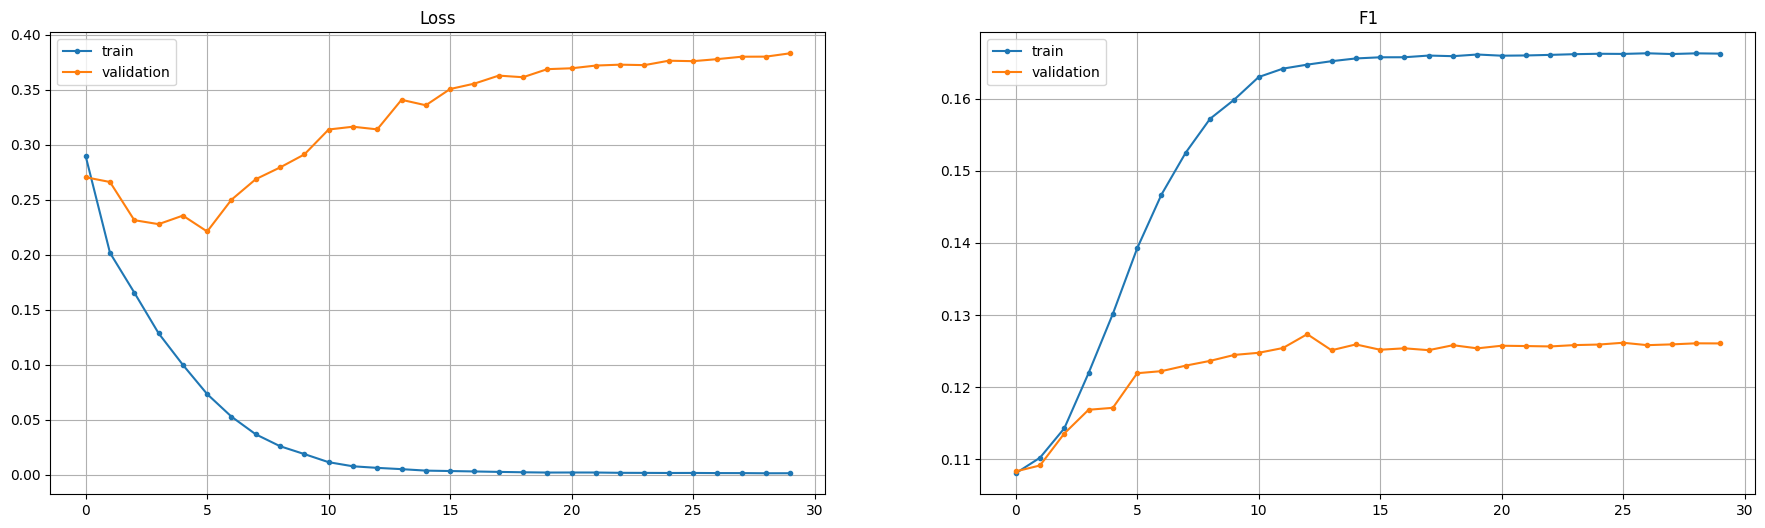

In [121]:
# NOTE: plot training and validation performance
fig, axes = plt.subplots(ncols=2, figsize=(22, 6))

axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
axes[0].legend(["train", "validation"])
axes[0].set_title("Loss")
axes[0].grid()

axes[1].plot(np.arange(len(train_scores)), [item.mean() for item in train_scores], ".-")
axes[1].plot(np.arange(len(valid_scores)), [item.mean() for item in valid_scores], ".-")
axes[1].legend(["train", "validation"])
axes[1].set_title("F1")
axes[1].grid();

# Graph below for NER RNN GRU ATTENTION

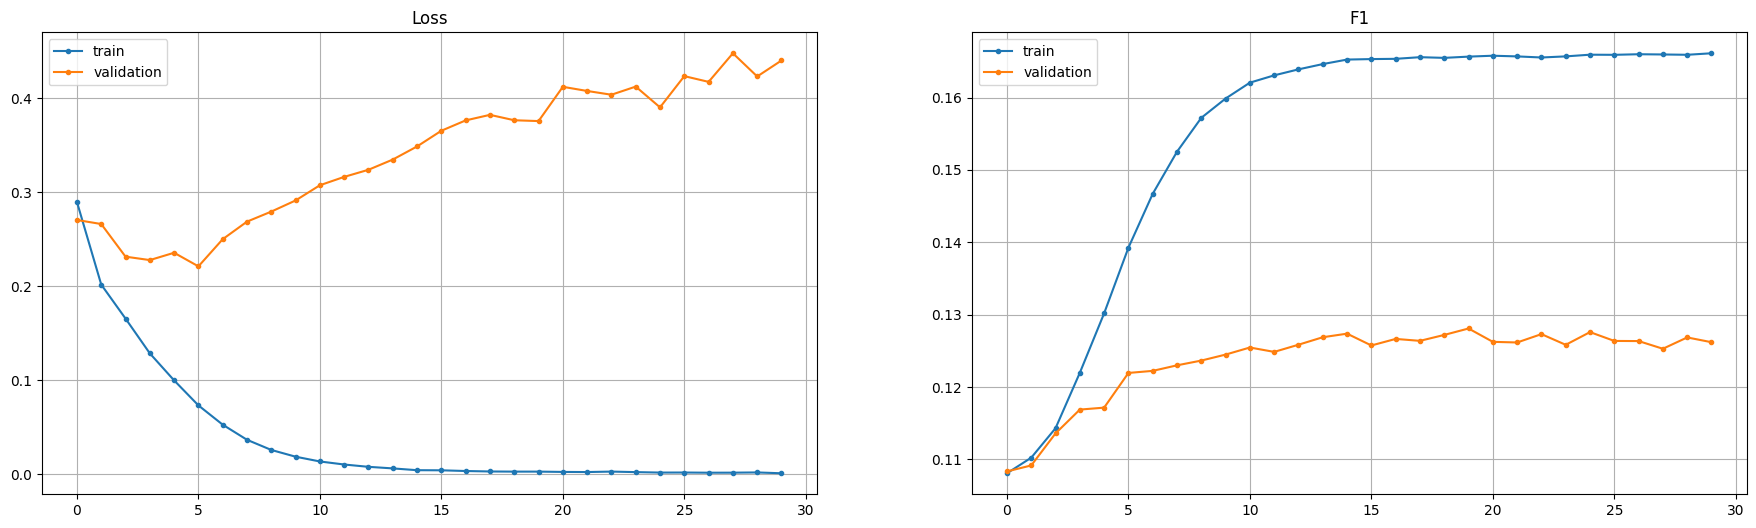

# Graph below for NER RNN GRU ATTENTION WITH LEARNING SCHEDULER

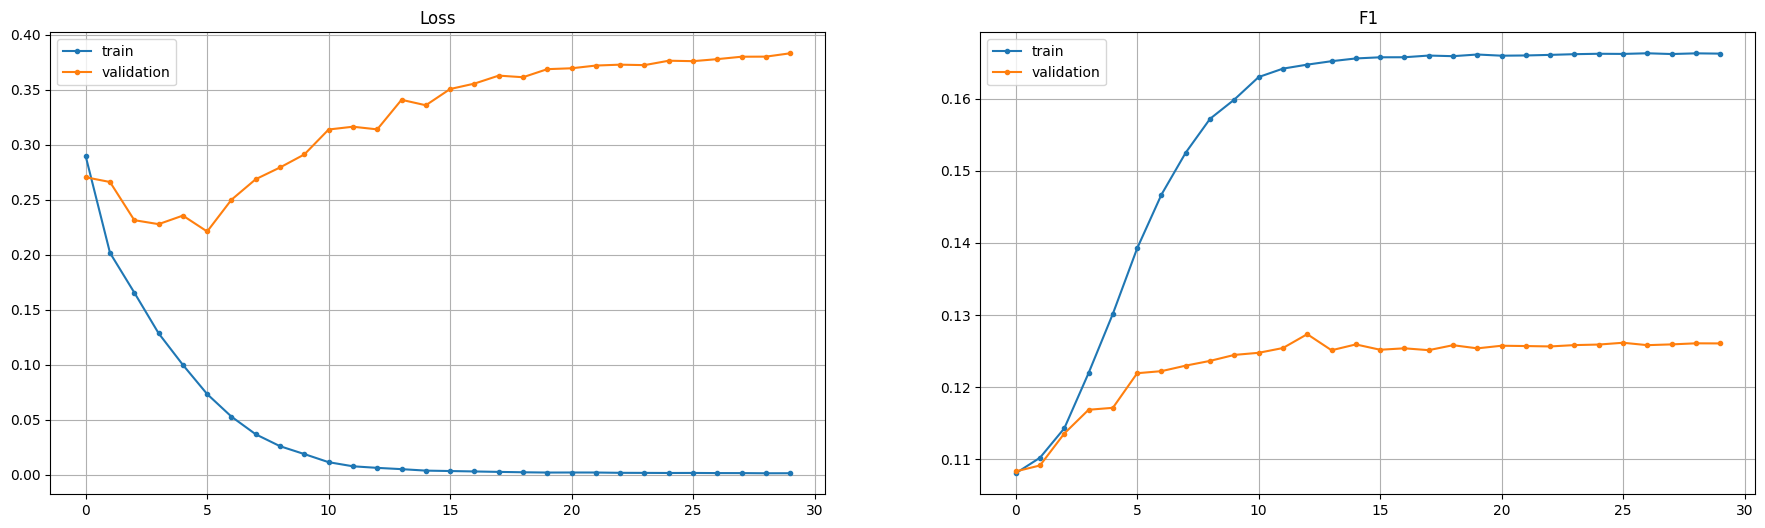

# Graph below for NER RNN LSTM

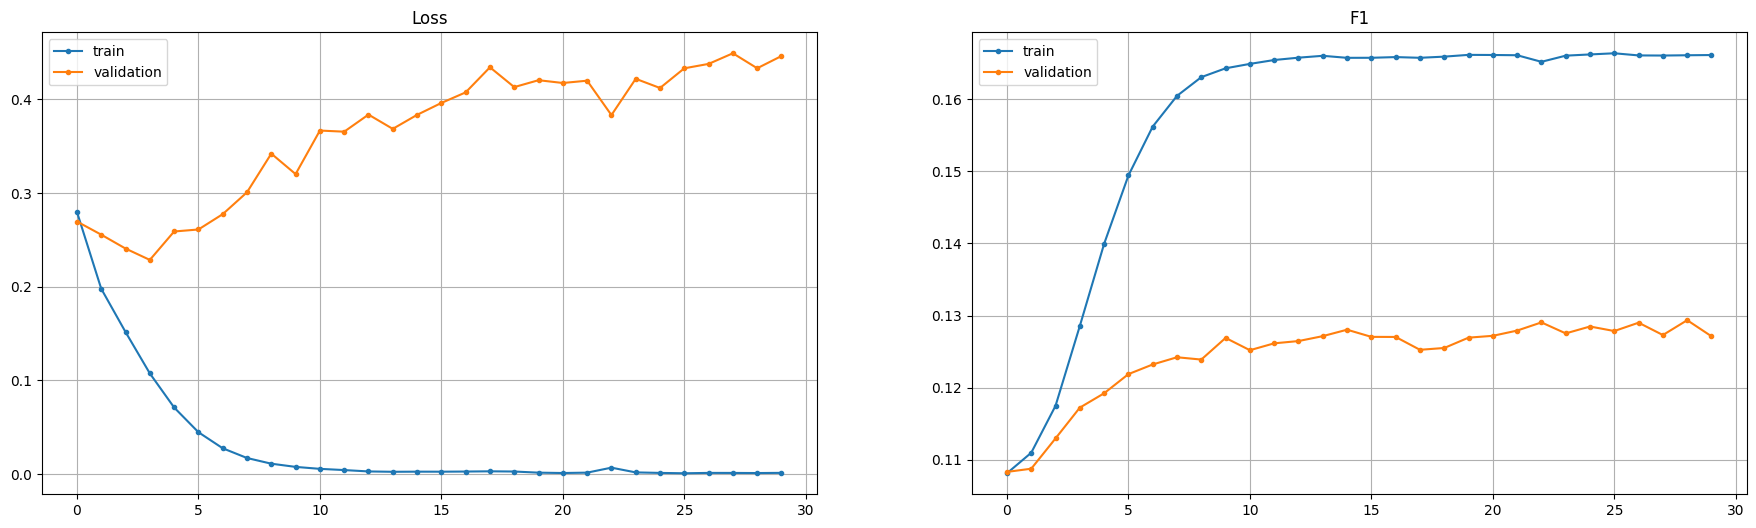

In [123]:
#######################################################################
# TODO: load model best state TASK 1 ✅
# TODO: write evaluation function for a test set. TASK 2 ✅
#######################################################################

import os
import glob

#

model_metrics = {}

model_files = glob.glob(os.path.join(os.getcwd(), "*.pth"))

for model_file in model_files:

    model_name = os.path.splitext(os.path.basename(model_file))[0]
    if model_name == "NER_RNN_GRU":
      model = NER_RNN(len(vocab), 512, 512, 3, len(targets))
    elif model_name == "NER_RNN_GRU_ATTENTION":
      model = NER_RNN_MOD(len(vocab), 512, 512, 3, len(targets))
    elif model_name == "NER_RNN_GRU_ATTENTION_WITH_LEARNING_SCHEDULER":
      model = NER_RNN_MOD(len(vocab), 512, 512, 3, len(targets))
    elif model_name == "NER_RNN_LSTM":
      model = NER_RNN_LSTM(len(vocab), 512, 512, 3, len(targets))
    else:
      continue
    best_state = torch.load(model_file, map_location=device) # TASK 1 ✅
    model.load_state_dict(best_state['model_state_dict'])
    model.to(device)

    # Evaluate the model on the test set
    # В нас вже написана evaluate() для @torch.inference_mode(), тому ми можемо
    # використати її (не бачу що змінювати)
    test_logs = evaluate(model, test_loader, criterion, device) # TASK 2 ✅

    model_metrics[model_name] = {
        "Loss": np.mean(test_logs["losses"]),
        "F1": np.mean(test_logs["f1"], 0)
    }

for model_name, metrics in model_metrics.items():
    print(f"Model: {model_name}")
    print(f"  Loss: {metrics['Loss']:.4f}")
    print(f"  F1 Score: {metrics['F1']}")

<ipython-input-123-f1f857d8cd4d>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state = torch.load(model_file, map_location=device) # TASK 1 ✅


evaluation:   9%|████▋                                               | 1/11 [00:00<00:01,  7.52it/s]

<ipython-input-113-1a8d18e29ee3>:21: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-113-1a8d18e29ee3>:22: RuntimeWarning: invalid value encountered in scalar divide
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)
<ipython-input-113-1a8d18e29ee3>:23: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)


evaluation: 100%|███████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.79it/s]
Model: NER_RNN_GRU_ATTENTION
  Loss: 0.4122
  F1 Score: [0.97730335 0.09625511 0.01531936 0.01322355 0.00647039 0.03163673
 0.00299401 0.01063755 0.00529417]
Model: NER_RNN_LSTM
  Loss: 0.4687
  F1 Score: [0.9793443  0.11272455 0.01981038 0.01357285 0.00537259 0.03203593
 0.00449102 0.00701929 0.00394173]
Model: NER_RNN_GRU
  Loss: 0.4525
  F1 Score: [0.97823857 0.09235004 0.01726547 0.01022954 0.00469062 0.032248
 0.00299401 0.00582169 0.00607357]
Model: NER_RNN_GRU_ATTENTION_WITH_LEARNING_SCHEDULER
  Loss: 0.3399
  F1 Score: [0.9772314  0.09407613 0.01477046 0.01097804 0.00566331 0.0249002
 0.00149701 0.00618762 0.00138433]


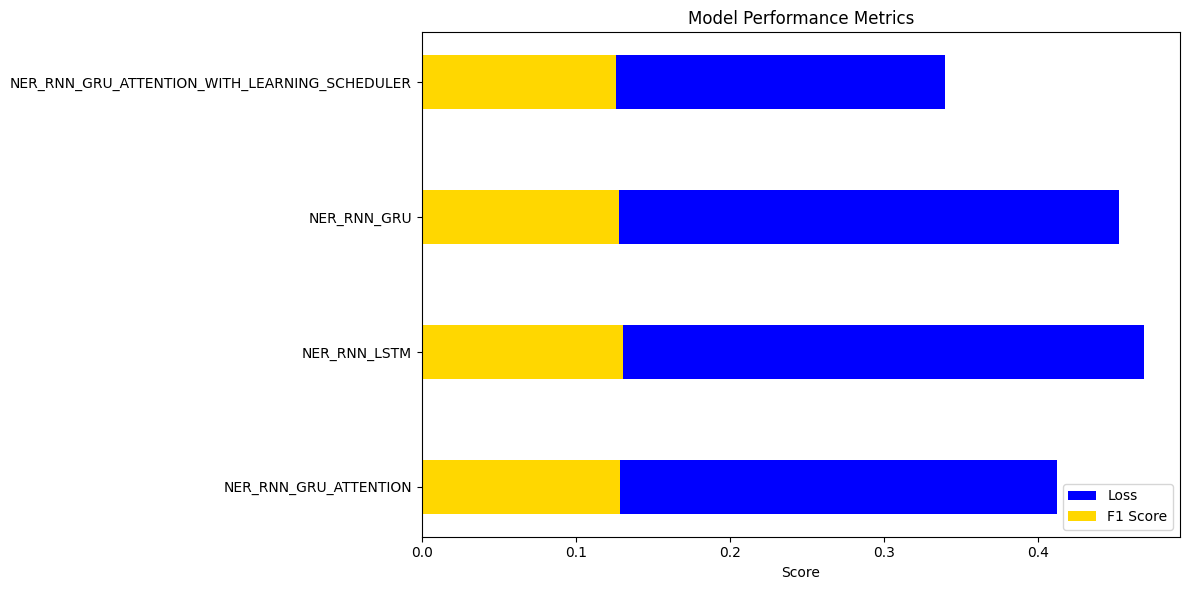

In [124]:
# Credits for visualization help: Claude 3.7

model_names = list(model_metrics.keys())
losses = [metrics['Loss'] for metrics in model_metrics.values()]
f1_scores = [np.mean(metrics['F1']) for metrics in model_metrics.values()]  # Average F1 score

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Define bar positions
y_pos = np.arange(len(model_names))  # Positions for the models

# Plot Loss bars (background)
ax.barh(y_pos, losses, color='blue', label='Loss', height=0.4)

# Plot F1 Score bars (foreground, overlapping)
ax.barh(y_pos, f1_scores, color='gold', label='F1 Score', height=0.4)

# Set y-axis labels (model names)
ax.set_yticks(y_pos)
ax.set_yticklabels(model_names)

# Set axis labels and title
ax.set_xlabel('Score')
ax.set_title('Model Performance Metrics')

# Add legend
plt.legend(loc='lower right')

# Display the plot
plt.tight_layout()
plt.show()